In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
#psi4.core.set_output_file('output.dat', False)
import time
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from numpy.polynomial import Chebyshev
from scipy import constants

In [2]:
def chebyshev_nodes(n):
    return 0.5 * (1.0 - np.cos(np.pi * (2.0 * np.arange(1, n + 1) - 1) / (2.0 * n)))

def create_chebyshev_grid(start, end, num_points):
    nodes = chebyshev_nodes(num_points)
    scaled_nodes = start + nodes * (end - start)
    return scaled_nodes

r_array_g = create_chebyshev_grid(0.73, 0.8, 50)

r_array_e = create_chebyshev_grid(0.73, 4, 50)

In [3]:
# setup basic arguments for qed-ci calculation

# z-matrix for H2
mol_str_CO = """
H
H 1 0.74
symmetry c1
"""

# options for Psi4
options_dict = {
    #"energy": "CCSD",
    "basis": "6-311G**",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.05]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}



In [4]:
# template for the z-matrix so we can scan through bond lengths
mol_tmpl_CO = """
H
H 1 **R**
symmetry c1
"""


# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el = 4

#r_array = np.linspace(0.2, 2.2, N_R)


# array for energies for CO outside cavity
cavity_free_E_array_CO = np.zeros((N_R, N_el))

# array  for energies inside the cavity
cavity_E_array_CO = np.zeros((N_R, N_el))

r_idx_CO = 0
for r in r_array_g:
    mol_str_CO = mol_tmpl_CO.replace("**R**", str(r))
    mol_CO = psi4.geometry(mol_str_CO)
    print(mol_str_CO)
    
    # call psi4 RHF
    scf_e, wfn_CO = psi4.energy('CCSD/6-311G**', return_wfn=True)
    
    # call psi4 FCI
    fci_energy_CO = psi4.energy('fci/6-311G**',ref_wfn=wfn_CO)
    
    # CO no cavity
    CO = PFHamiltonianGenerator(mol_str_CO, options_dict, cavity_free_dict)

    # check to make sure PFHamiltonian cavity-free FCI ground-state agrees with psi4
    assert np.isclose(CO.CIeigs[0], fci_energy_CO)
    
    # CO with cavity
    CO_cav = PFHamiltonianGenerator(mol_str_CO, options_dict, cavity_dict)
    cavity_free_E_array_CO[r_idx_CO,:] = CO.CIeigs[:N_el]
    cavity_E_array_CO[r_idx_CO,:] = CO_cav.CIeigs[:N_el]
    r_idx_CO += 1
    
    
    


H
H 1 0.7300172703871993
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:05 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point gro

 Completed Hamiltonian build in 0.5230720043182373 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:06 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =       1.41 seconds =       0.02 minutes
	system time =       0.22 seconds =       0.00 minutes
	total time  =          2 seconds =       0.03 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals

 Completed Hamiltonian build in 0.5366790294647217 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:08 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:08 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transforma

 Completed Hamiltonian build in 0.5299639701843262 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:09 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =       4.13 seconds =       0.07 minutes
	system time =       0.64 seconds =       0.01 minutes
	total time  =          5 seconds =       0.08 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals

 Completed Hamiltonian build in 0.5226080417633057 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:11 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OO|OV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OO|VV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OV|OO)...
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-elect

 Completed Hamiltonian build in 0.5607969760894775 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:12 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:13 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OO|OV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.


 Completed Hamiltonian build in 0.5266208648681641 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:14 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c



  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -0.596916  

    Virtual:                                                              

       2A      0.167358     3A      0.306194     4A      0.646712  
       5A      1.333312     6A      1.333312     7A      1.822060  
       8A      2.103653     9A      2.103653    10A      2.193687  
      11A      2.709355    12A      3.727078  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]
    NA   [     1 ]
    NB   [     1 ]

  @RHF Final Energy:    -1.13248601687015

   => Energetics <=

    Nuclear Repulsion Energy =              0.7220530375176262
    One-Electron Energy =                  -2.5152458792084404
    Two-Electron Energy =                   0.6607068248206659
    Total Energy =                         -1.1324860168701485

Computation Completed


Properties will be evaluated at   0.0000

 Completed Hamiltonian build in 0.5395781993865967 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:15 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =       9.61 seconds =       0.16 minutes
	system time =       1.52 seconds =       0.03 minutes
	total time  =         11 seconds =       0.18 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals

 Completed Hamiltonian build in 0.5210611820220947 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:17 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.06 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      10.97 seconds =       0.18 minutes
	system time =       1.72 seconds =       0.03 minutes
	total time  =         13 seconds =       0.22 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5233030319213867 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:18 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c


*** tstop() called on CHEMYM0V4HTALT at Mon Nov 27 11:13:19 2023
Module time:
	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      12.32 seconds =       0.21 minutes
	system time =       1.92 seconds =       0.03 minutes
	total time  =         14 seconds =       0.23 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole in

 Completed Hamiltonian build in 0.5193660259246826 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:20 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      13.67 seconds =       0.23 minutes
	system time =       2.12 seconds =       0.04 minutes
	total time  =         16 seconds =       0.27 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals

 Completed Hamiltonian build in 0.5293171405792236 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:22 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c



  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -0.595101  

    Virtual:                                                              

       2A      0.166562     3A      0.306673     4A      0.644788  
       5A      1.332631     6A      1.332631     7A      1.818922  
       8A      2.099499     9A      2.099499    10A      2.203156  
      11A      2.709794    12A      3.693132  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]
    NA   [     1 ]
    NB   [     1 ]

  @RHF Final Energy:    -1.13248329972044

   => Energetics <=

    Nuclear Repulsion Energy =              0.7163180985604433
    One-Electron Energy =                  -2.5074015502195759
    Two-Electron Energy =                   0.6586001519386911
    Total Energy =                         -1.1324832997204415

Computation Completed


Properties will be evaluated at   0.0000

 Completed Hamiltonian build in 0.5219662189483643 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:23 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

Properties will be evaluated at   0.000000,   0.000000,   0.000000 [a0]

Properties computed using the SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :         -0.0000000            0.0000000           -0.0000000
 Dipole Y            :          0.0000000            0.0000000            0.0000000
 Dipole Z            :         -0.0000000            0.0000000           -0.0000000
 Magnitude           :                                                    0.0000000

 ------------------------------------------------------------------------------------

*** tstop() called on CHEMYM0V4HTALT at Mon Nov 27 11:13:24 2023
Module time:
	user time   =       0.05 second

 Completed Hamiltonian build in 0.5215919017791748 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:25 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      17.74 seconds =       0.30 minutes
	system time =       2.73 seconds =       0.05 minutes
	total time  =         20 seconds =       0.33 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5242800712585449 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:26 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OO|OV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OO|VV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OV|OO)...
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-elect

 Completed Hamiltonian build in 0.5031700134277344 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:28 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c



  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -0.593081  

    Virtual:                                                              

       2A      0.165659     3A      0.307210     4A      0.642616  
       5A      1.331896     6A      1.331896     7A      1.815323  
       8A      2.094843     9A      2.094843    10A      2.213972  
      11A      2.710245    12A      3.656067  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]
    NA   [     1 ]
    NB   [     1 ]

  @RHF Final Energy:    -1.13242264235951

   => Energetics <=

    Nuclear Repulsion Energy =              0.7099932682033205
    One-Electron Energy =                  -2.4986705877833613
    Two-Electron Energy =                   0.6562546772205335
    Total Energy =                         -1.1324226423595072

Computation Completed


Properties will be evaluated at   0.0000

 Completed Hamiltonian build in 0.5197350978851318 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:29 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:30 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transforma

 Completed Hamiltonian build in 0.5220060348510742 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:31 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OO|OV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OO|VV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OV|OO)...
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-elect

 Completed Hamiltonian build in 0.5239858627319336 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:32 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

Properties will be evaluated at   0.000000,   0.000000,   0.000000 [a0]

Properties computed using the SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :         -0.0000000            0.0000000           -0.0000000
 Dipole Y            :          0.0000000            0.0000000            0.0000000
 Dipole Z            :         -0.0000000            0.0000000           -0.0000000
 Magnitude           :                                                    0.0000000

 ------------------------------------------------------------------------------------

*** tstop() called on CHEMYM0V4HTALT at Mon Nov 27 11:13:33 2023
Module time:
	user time   =       0.05 second

 Completed Hamiltonian build in 0.5191521644592285 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:34 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:35 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semica

 Completed Hamiltonian build in 0.5259897708892822 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:35 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      27.20 seconds =       0.45 minutes
	system time =       4.10 seconds =       0.07 minutes
	total time  =         31 seconds =       0.52 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5185108184814453 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:37 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =       4.30 seconds =       0.07 minutes
	total time  =         33 seconds =       0.55 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:38 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Numbe

 Completed Hamiltonian build in 0.5274360179901123 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:39 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c



  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -0.588780  

    Virtual:                                                              

       2A      0.163677     3A      0.308372     4A      0.637884  
       5A      1.330414     6A      1.330414     7A      1.807277  
       8A      2.084805     9A      2.084805    10A      2.237886  
      11A      2.711065    12A      3.579652  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]
    NA   [     1 ]
    NB   [     1 ]

  @RHF Final Energy:    -1.13209549256631

   => Energetics <=

    Nuclear Repulsion Energy =              0.6967214435169310
    One-Electron Energy =                  -2.4800730934860473
    Two-Electron Energy =                   0.6512561574028055
    Total Energy =                         -1.1320954925663109

Computation Completed


Properties will be evaluated at   0.0000

 Completed Hamiltonian build in 0.5226881504058838 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:40 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:41 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.

 Completed Hamiltonian build in 0.5255608558654785 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:42 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:42 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transforma

 Completed Hamiltonian build in 0.5207998752593994 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:43 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      33.97 seconds =       0.57 minutes
	system time =       5.08 seconds =       0.08 minutes
	total time  =         39 seconds =       0.65 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals

 Completed Hamiltonian build in 0.5251052379608154 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:45 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      35.32 seconds =       0.59 minutes
	system time =       5.27 seconds =       0.09 minutes
	total time  =         40 seconds =       0.67 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals

 Completed Hamiltonian build in 0.5195868015289307 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:46 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:47 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semica

 Completed Hamiltonian build in 0.527522087097168 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:48 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1

 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:48 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semica

 Completed Hamiltonian build in 0.522536039352417 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:49 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1

 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:50 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semica

 Completed Hamiltonian build in 0.5257000923156738 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:51 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:52 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.

 Completed Hamiltonian build in 0.5223100185394287 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:52 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      42.10 seconds =       0.70 minutes
	system time =       6.28 seconds =       0.10 minutes
	total time  =         48 seconds =       0.80 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on C

 Completed Hamiltonian build in 0.5237607955932617 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:54 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      43.45 seconds =       0.72 minutes
	system time =       6.49 seconds =       0.11 minutes
	total time  =         50 seconds =       0.83 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals

 Completed Hamiltonian build in 0.5188426971435547 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:56 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      44.80 seconds =       0.75 minutes
	system time =       6.69 seconds =       0.11 minutes
	total time  =         51 seconds =       0.85 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals

 Completed Hamiltonian build in 0.5252242088317871 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:57 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.06 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      46.16 seconds =       0.77 minutes
	system time =       6.89 seconds =       0.11 minutes
	total time  =         53 seconds =       0.88 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5252571105957031 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:13:59 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         12      12 
   -------------------------
    Total      12      12
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -0.84674246722556   -8.46742e-01   0.00000e+00 
   @RHF iter   1:    -1.12800793327411   -2.81265e-01   3.83156e-03 ADIIS/DIIS
   @RHF iter   2:    -1.13068895854729   -2.68103e-03   7.60920e-04 ADIIS/DIIS
   @RHF iter   3:    -1.13080679933385   -1.17841e-04   6.41198e-05 DIIS
   @RHF iter   4:    -1.13080733944863   -5.40115e-07   1.16586e-06 DIIS
   @RHF iter   5:    -1.13080733961560   -1.66973e-10   1.13922e-07 DIIS
   @RHF iter   6:    -1.13080733961787   -2.26774e-12   4.74355e-10 DIIS
   @RHF iter   7:    -1.13080733961787   -8.88178e-16   4.18954e-13 DIIS
  Energy and wav

 Completed Hamiltonian build in 0.5225601196289062 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:00 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:01 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    1

 Completed Hamiltonian build in 0.5223231315612793 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:02 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      50.21 seconds =       0.84 minutes
	system time =       7.50 seconds =       0.12 minutes
	total time  =         57 seconds =       0.95 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5196599960327148 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:03 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:04 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transforma

 Completed Hamiltonian build in 0.5235178470611572 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:05 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:05 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semica

 Completed Hamiltonian build in 0.519118070602417 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:06 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         12      12 
   -------------------------
    Total      12      12
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -0.84716102085874   -8.47161e-01   0.00000e+00 
   @RHF iter   1:    -1.12753108077274   -2.80370e-01   3.81401e-03 ADIIS/DIIS
   @RHF iter   2:    -1.13019078730254   -2.65971e-03   7.57053e-04 ADIIS/DIIS
   @RHF iter   3:    -1.13030769254159   -1.16905e-04   6.37639e-05 DIIS
   @RHF iter   4:    -1.13030822777087   -5.35229e-07   1.16298e-06 DIIS
   @RHF iter   5:    -1.13030822793624   -1.65372e-10   1.12721e-07 DIIS
   @RHF iter   6:    -1.13030822793847   -2.23155e-12   4.61748e-10 DIIS
   @RHF iter   7:    -1.13030822793847    1.77636e-15   4.03714e-13 DIIS
  Energy and wav

 Completed Hamiltonian build in 0.523918628692627 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:08 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          1 seconds =       0.02 minutes
Total time:
	user time   =      55.62 seconds =       0.93 minutes
	system time =       8.28 seconds =       0.14 minutes
	total time  =         64 seconds =       1.07 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5202229022979736 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:09 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:10 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semica

 Completed Hamiltonian build in 0.5205018520355225 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:11 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      58.32 seconds =       0.97 minutes
	system time =       8.67 seconds =       0.14 minutes
	total time  =         67 seconds =       1.12 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.525475025177002 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:12 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      59.68 seconds =       0.99 minutes
	system time =       8.87 seconds =       0.15 minutes
	total time  =         68 seconds =       1.13 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5231590270996094 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:14 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:15 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OO|OV)...
	Starting second half-transformat

 Completed Hamiltonian build in 0.5181760787963867 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:16 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      62.40 seconds =       1.04 minutes
	system time =       9.27 seconds =       0.15 minutes
	total time  =         71 seconds =       1.18 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals

 Completed Hamiltonian build in 0.519207239151001 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:17 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1



  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -0.577064  

    Virtual:                                                              

       2A      0.157833     3A      0.311669     4A      0.624239  
       5A      1.327021     6A      1.327021     7A      1.782643  
       8A      2.056588     9A      2.056588    10A      2.307508  
      11A      2.712254    12A      3.388688  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]
    NA   [     1 ]
    NB   [     1 ]

  @RHF Final Energy:    -1.12989705962720

   => Energetics <=

    Nuclear Repulsion Energy =              0.6618279971262284
    One-Electron Energy =                  -2.4293217980651867
    Two-Electron Energy =                   0.6375967413117603
    Total Energy =                         -1.1298970596271980

Computation Completed


Properties will be evaluated at   0.0000

 Completed Hamiltonian build in 0.5280022621154785 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:19 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      65.11 seconds =       1.09 minutes
	system time =       9.67 seconds =       0.16 minutes
	total time  =         74 seconds =       1.23 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5175230503082275 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:20 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:21 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OO|OV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.


 Completed Hamiltonian build in 0.5215628147125244 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:22 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

In [5]:
# array for energies for CO outside cavity
cavity_free_E_array_e = np.zeros((N_R, N_el))

# array  for energies inside the cavity
cavity_E_array_e = np.zeros((N_R, N_el))

r_idx_CO = 0
for r in r_array_e:
    mol_str_CO = mol_tmpl_CO.replace("**R**", str(r))
    mol_CO = psi4.geometry(mol_str_CO)
    print(mol_str_CO)
    
    # call psi4 RHF
    scf_e, wfn_CO = psi4.energy('CCSD/6-311G**', return_wfn=True)
    
    # call psi4 FCI
    fci_energy_CO = psi4.energy('fci/6-311G**',ref_wfn=wfn_CO)
    
    # CO no cavity
    CO = PFHamiltonianGenerator(mol_str_CO, options_dict, cavity_free_dict)

    # check to make sure PFHamiltonian cavity-free FCI ground-state agrees with psi4
    assert np.isclose(CO.CIeigs[0], fci_energy_CO)
    
    # CO with cavity
    CO_cav = PFHamiltonianGenerator(mol_str_CO, options_dict, cavity_dict)
    cavity_free_E_array_e[r_idx_CO,:] = CO.CIeigs[:N_el]
    cavity_E_array_e[r_idx_CO,:] = CO_cav.CIeigs[:N_el]
    r_idx_CO += 1


H
H 1 0.7308067738020289
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:49 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point gro

 Completed Hamiltonian build in 0.5223379135131836 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:50 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      69.18 seconds =       1.15 minutes
	system time =      10.23 seconds =       0.17 minutes
	total time  =        105 seconds =       1.75 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5211451053619385 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:51 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         12      12 
   -------------------------
    Total      12      12
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -0.84353322413828   -8.43533e-01   0.00000e+00 
   @RHF iter   1:    -1.12943329457474   -2.85900e-01   3.91668e-03 ADIIS/DIIS
   @RHF iter   2:    -1.13221829250288   -2.78500e-03   7.79967e-04 ADIIS/DIIS
   @RHF iter   3:    -1.13234072975935   -1.22437e-04   6.57876e-05 DIIS
   @RHF iter   4:    -1.13234129262628   -5.62867e-07   1.17986e-06 DIIS
   @RHF iter   5:    -1.13234129280070   -1.74426e-10   1.19758e-07 DIIS
   @RHF iter   6:    -1.13234129280317   -2.47047e-12   5.40111e-10 DIIS
   @RHF iter   7:    -1.13234129280317    8.88178e-16   5.00746e-13 DIIS
  Energy and wav

 Completed Hamiltonian build in 0.5223939418792725 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:53 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      71.88 seconds =       1.20 minutes
	system time =      10.63 seconds =       0.18 minutes
	total time  =        108 seconds =       1.80 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.524407148361206 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:54 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      73.24 seconds =       1.22 minutes
	system time =      10.83 seconds =       0.18 minutes
	total time  =        110 seconds =       1.83 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5207486152648926 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:56 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:57 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semica

 Completed Hamiltonian build in 0.5218920707702637 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:57 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:58 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semica

 Completed Hamiltonian build in 0.5200347900390625 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:14:59 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      77.29 seconds =       1.29 minutes
	system time =      11.44 seconds =       0.19 minutes
	total time  =        115 seconds =       1.92 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5198400020599365 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:01 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:01 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semica

 Completed Hamiltonian build in 0.52052903175354 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:02 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1




  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -0.523672  

    Virtual:                                                              

       2A      0.121601     3A      0.329854     4A      0.552486  
       5A      1.330166     6A      1.330166     7A      1.618843  
       8A      1.911903     9A      1.911903    10A      2.536855  
      11A      2.692662    12A      2.851164  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]
    NA   [     1 ]
    NB   [     1 ]

  @RHF Final Energy:    -1.09924190207886

   => Energetics <=

    Nuclear Repulsion Energy =              0.5225289385725663
    One-Electron Energy =                  -2.1961978717774522
    Two-Electron Energy =                   0.5744270311260252
    Total Energy =                         -1.0992419020788606

Computation Completed


Properties will be evaluated at   0.0000

 Completed Hamiltonian build in 0.5191769599914551 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:04 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c


*** tstop() called on CHEMYM0V4HTALT at Mon Nov 27 11:15:04 2023
Module time:
	user time   =       0.06 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      81.35 seconds =       1.36 minutes
	system time =      12.08 seconds =       0.20 minutes
	total time  =        119 seconds =       1.98 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole in

 Completed Hamiltonian build in 0.5199580192565918 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:05 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      82.70 seconds =       1.38 minutes
	system time =      12.28 seconds =       0.20 minutes
	total time  =        121 seconds =       2.02 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals

 Completed Hamiltonian build in 0.523468017578125 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:07 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1

	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OO|OV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OO|VV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OV|OO)...
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-elect

 Completed Hamiltonian build in 0.5199151039123535 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:08 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      85.40 seconds =       1.42 minutes
	system time =      12.70 seconds =       0.21 minutes
	total time  =        124 seconds =       2.07 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on C

 Completed Hamiltonian build in 0.5224761962890625 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:10 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	total time  =          1 seconds =       0.02 minutes
Total time:
	user time   =      86.75 seconds =       1.45 minutes
	system time =      12.91 seconds =       0.22 minutes
	total time  =        126 seconds =       2.10 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on C

 Completed Hamiltonian build in 0.5193960666656494 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:11 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =      88.10 seconds =       1.47 minutes
	system time =      13.14 seconds =       0.22 minutes
	total time  =        127 seconds =       2.12 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:12 2023


	Wfn Parameters:
	-

 Completed Hamiltonian build in 0.5187969207763672 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:13 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:14 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.

 Completed Hamiltonian build in 0.5178020000457764 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:15 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

    ---------------------

    Doubly Occupied:                                                      

       1A     -0.426353  

    Virtual:                                                              

       2A      0.009052     3A      0.383821     4A      0.437633  
       5A      1.292219     6A      1.455652     7A      1.455652  
       8A      1.616739     9A      1.616739    10A      1.979968  
      11A      2.496173    12A      2.719132  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]
    NA   [     1 ]
    NB   [     1 ]

  @RHF Final Energy:    -0.98116367641732

   => Energetics <=

    Nuclear Repulsion Energy =              0.3261039528452306
    One-Electron Energy =                  -1.7618289425051974
    Two-Electron Energy =                   0.4545613132426440
    Total Energy =                         -0.9811636764173228

Computation Completed


Properties will be evaluated at   0.000000,   0.000000,   0.000000 [a0]

Properties computed us

 Completed Hamiltonian build in 0.5189292430877686 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:16 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.06 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      92.14 seconds =       1.54 minutes
	system time =      13.79 seconds =       0.23 minutes
	total time  =        132 seconds =       2.20 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5186758041381836 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:18 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

    ---------------------

    Doubly Occupied:                                                      

       1A     -0.406503  

    Virtual:                                                              

       2A     -0.019779     3A      0.399832     4A      0.422874  
       5A      1.317868     6A      1.482835     7A      1.482835  
       8A      1.570533     9A      1.570533    10A      1.835613  
      11A      2.447906    12A      2.652970  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]
    NA   [     1 ]
    NB   [     1 ]

  @RHF Final Energy:    -0.95058186777091

   => Energetics <=

    Nuclear Repulsion Energy =              0.2921752843149926
    One-Electron Energy =                  -1.6725082516447303
    Two-Electron Energy =                   0.4297510995588302
    Total Energy =                         -0.9505818677709075

Computation Completed


Properties will be evaluated at   0.000000,   0.000000,   0.000000 [a0]

Properties computed us

 Completed Hamiltonian build in 0.520427942276001 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:19 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1

Properties computed using the SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :          0.0000000            0.0000000            0.0000000
 Dipole Y            :          0.0000000            0.0000000            0.0000000
 Dipole Z            :         -0.0000000            0.0000000           -0.0000000
 Magnitude           :                                                    0.0000000

 ------------------------------------------------------------------------------------

*** tstop() called on CHEMYM0V4HTALT at Mon Nov 27 11:15:20 2023
Module time:
	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 min

 Completed Hamiltonian build in 0.5207688808441162 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:21 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      96.18 seconds =       1.60 minutes
	system time =      14.45 seconds =       0.24 minutes
	total time  =        136 seconds =       2.27 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5388319492340088 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:22 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:23 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.

 Completed Hamiltonian build in 0.5174961090087891 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:24 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

    ---------------------

    Doubly Occupied:                                                      

       1A     -0.373215  

    Virtual:                                                              

       2A     -0.067406     3A      0.408164     4A      0.415068  
       5A      1.448359     6A      1.503498     7A      1.503498  
       8A      1.522800     9A      1.522800    10A      1.628768  
      11A      2.441893    12A      2.547920  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]
    NA   [     1 ]
    NB   [     1 ]

  @RHF Final Energy:    -0.89799715020809

   => Energetics <=

    Nuclear Repulsion Energy =              0.2393240174850668
    One-Electron Energy =                  -1.5282129609106074
    Two-Electron Energy =                   0.3908917932174473
    Total Energy =                         -0.8979971502080933

Computation Completed


Properties will be evaluated at   0.000000,   0.000000,   0.000000 [a0]

Properties computed us

 Completed Hamiltonian build in 0.5211381912231445 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:26 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     100.24 seconds =       1.67 minutes
	system time =      15.14 seconds =       0.25 minutes
	total time  =        141 seconds =       2.35 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5185110569000244 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:27 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:28 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.

 Completed Hamiltonian build in 0.5454950332641602 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:29 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:29 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.

 Completed Hamiltonian build in 0.5552220344543457 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:30 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     104.37 seconds =       1.74 minutes
	system time =      15.97 seconds =       0.27 minutes
	total time  =        146 seconds =       2.43 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5488698482513428 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:32 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

    ---------------------

    Doubly Occupied:                                                      

       1A     -0.342443  

    Virtual:                                                              

       2A     -0.107267     3A      0.396690     4A      0.411250  
       5A      1.502317     6A      1.502317     7A      1.503505  
       8A      1.505995     9A      1.505995    10A      1.531484  
      11A      2.484844    12A      2.488120  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]
    NA   [     1 ]
    NB   [     1 ]

  @RHF Final Energy:    -0.85037593090463

   => Energetics <=

    Nuclear Repulsion Energy =              0.1944314845055343
    One-Electron Energy =                  -1.4047290781551349
    Two-Electron Energy =                   0.3599216627449745
    Total Energy =                         -0.8503759309046263

Computation Completed


Properties will be evaluated at   0.000000,   0.000000,   0.000000 [a0]

Properties computed us

 Completed Hamiltonian build in 0.5264639854431152 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:34 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.06 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     107.11 seconds =       1.79 minutes
	system time =      16.48 seconds =       0.27 minutes
	total time  =        149 seconds =       2.48 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5293822288513184 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:35 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         12      12 
   -------------------------
    Total      12      12
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -0.71500300596852   -7.15003e-01   0.00000e+00 
   @RHF iter   1:    -0.83634112617441   -1.21338e-01   9.00945e-04 ADIIS/DIIS
   @RHF iter   2:    -0.83641468723823   -7.35611e-05   1.11445e-04 ADIIS/DIIS
   @RHF iter   3:    -0.83641592229053   -1.23505e-06   3.48818e-06 DIIS
   @RHF iter   4:    -0.83641592483804   -2.54751e-09   1.18846e-07 DIIS
   @RHF iter   5:    -0.83641592484131   -3.26850e-12   8.43124e-10 DIIS
   @RHF iter   6:    -0.83641592484131    6.66134e-16   7.03214e-15 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [

 Completed Hamiltonian build in 0.5222640037536621 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:37 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     109.81 seconds =       1.83 minutes
	system time =      16.94 seconds =       0.28 minutes
	total time  =        152 seconds =       2.53 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1101 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on C

 Completed Hamiltonian build in 0.5220859050750732 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:38 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

Properties computed using the SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :          0.0000000            0.0000000            0.0000000
 Dipole Y            :          0.0000000            0.0000000            0.0000000
 Dipole Z            :         -0.0000000            0.0000000           -0.0000000
 Magnitude           :                                                    0.0000000

 ------------------------------------------------------------------------------------

*** tstop() called on CHEMYM0V4HTALT at Mon Nov 27 11:15:39 2023
Module time:
	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 min

 Completed Hamiltonian build in 0.5260519981384277 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:40 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

Properties computed using the SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :         -0.0000000            0.0000000           -0.0000000
 Dipole Y            :         -0.0000000            0.0000000           -0.0000000
 Dipole Z            :          0.0000000            0.0000000            0.0000000
 Magnitude           :                                                    0.0000000

 ------------------------------------------------------------------------------------

*** tstop() called on CHEMYM0V4HTALT at Mon Nov 27 11:15:41 2023
Module time:
	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 min

 Completed Hamiltonian build in 0.5436849594116211 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:42 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     113.88 seconds =       1.90 minutes
	system time =      17.65 seconds =       0.29 minutes
	total time  =        157 seconds =       2.62 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5208888053894043 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:43 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

      Computing two-electron integrals...done
      Computed 1055 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:44 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.

 Completed Hamiltonian build in 0.527036190032959 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:45 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1

	user time   =     116.59 seconds =       1.94 minutes
	system time =      18.10 seconds =       0.30 minutes
	total time  =        160 seconds =       2.67 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1040 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:45 2023


	Wfn Parameters:
	-

 Completed Hamiltonian build in 0.5219509601593018 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:46 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     117.95 seconds =       1.97 minutes
	system time =      18.32 seconds =       0.31 minutes
	total time  =        162 seconds =       2.70 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1030 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on C

 Completed Hamiltonian build in 0.5232059955596924 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:48 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	Two-electron integral transformation complete.
	(OO|VV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OV|OO)...
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OV|OV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(OV|VV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(VV|OO)...
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(VV|OV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	(VV|VV)...
	Starting second half-transformation.
	Two-electron integral transformation complete.
	Frozen core energy     = 

 Completed Hamiltonian build in 0.5198218822479248 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:49 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

Properties computed using the SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :          0.0000000            0.0000000            0.0000000
 Dipole Y            :         -0.0000000            0.0000000           -0.0000000
 Dipole Z            :         -0.0000000            0.0000000           -0.0000000
 Magnitude           :                                                    0.0000000

 ------------------------------------------------------------------------------------

*** tstop() called on CHEMYM0V4HTALT at Mon Nov 27 11:15:50 2023
Module time:
	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 min

 Completed Hamiltonian build in 0.5185563564300537 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:51 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

Properties computed using the SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :          0.0000000            0.0000000            0.0000000
 Dipole Y            :          0.0000000            0.0000000            0.0000000
 Dipole Z            :          0.0000000            0.0000000            0.0000000
 Magnitude           :                                                    0.0000000

 ------------------------------------------------------------------------------------

*** tstop() called on CHEMYM0V4HTALT at Mon Nov 27 11:15:52 2023
Module time:
	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 min

 Completed Hamiltonian build in 0.530076265335083 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:53 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     123.35 seconds =       2.06 minutes
	system time =      19.21 seconds =       0.32 minutes
	total time  =        168 seconds =       2.80 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5284411907196045 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:54 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     124.71 seconds =       2.08 minutes
	system time =      19.43 seconds =       0.32 minutes
	total time  =        170 seconds =       2.83 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 954 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CH

 Completed Hamiltonian build in 0.5248618125915527 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:56 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

Properties computed using the SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :          0.0000000            0.0000000            0.0000000
 Dipole Y            :          0.0000000            0.0000000            0.0000000
 Dipole Z            :          0.0000000            0.0000000            0.0000000
 Magnitude           :                                                    0.0000000

 ------------------------------------------------------------------------------------

*** tstop() called on CHEMYM0V4HTALT at Mon Nov 27 11:15:56 2023
Module time:
	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 min

 Completed Hamiltonian build in 0.5351290702819824 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:57 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     127.44 seconds =       2.12 minutes
	system time =      19.92 seconds =       0.33 minutes
	total time  =        173 seconds =       2.88 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 926 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CH

 Completed Hamiltonian build in 0.5564460754394531 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:15:59 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	user time   =       0.06 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     128.84 seconds =       2.15 minutes
	system time =      20.18 seconds =       0.34 minutes
	total time  =        175 seconds =       2.92 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...d

 Completed Hamiltonian build in 0.5531520843505859 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:16:00 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

      Computing two-electron integrals...done
      Computed 924 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:16:01 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number of irreps     = 1
	Number of MOs        = 12
	Number of active MOs = 12
	AO-Basis             = NONE
	Semicanonical        = false
	Reference            = RHF
	Print Level          = 1

	IRREP	# MOs	# FZDC	# DOCC	# SOCC	# VIRT	# FZVR
	-----	-----	------	------	------	------	------
	 A	   12	    0	    1	    0	    11	    0
	Transforming integrals...
	IWL integrals will be deleted.
	(OO|OO)...
	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.


 Completed Hamiltonian build in 0.5228819847106934 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:16:02 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     131.57 seconds =       2.19 minutes
	system time =      20.65 seconds =       0.34 minutes
	total time  =        178 seconds =       2.97 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 922 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CH

 Completed Hamiltonian build in 0.5184049606323242 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:16:04 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =      20.85 seconds =       0.35 minutes
	total time  =        179 seconds =       2.98 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 914 non-zero two-electron integrals.
        Stored in file 33.


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:16:04 2023


	Wfn Parameters:
	--------------------
	Wavefunction         = CCSD
	Number

 Completed Hamiltonian build in 0.5171201229095459 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:16:05 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     134.25 seconds =       2.24 minutes
	system time =      21.06 seconds =       0.35 minutes
	total time  =        181 seconds =       3.02 minutes
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 910 non-zero two-electron integrals.

 Completed Hamiltonian build in 0.5368697643280029 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 27 11:16:07 2023

   => Loading Basis Set <=

    Name: 6-311G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    32 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/6-311gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c

In [6]:
# z-matrix for CO
mol_str_CO = """
H
H 1 0.74
symmetry c1
"""

# options dictionary for the psi4 calculation
options_dict0 = {'basis': '6-311G**',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-8,
               'd_convergence' : 1e-7
               }

# let's run a psi4 geometry optimization to get the optimal geometry

# set the options
psi4.set_options(options_dict0)

# first set the coordinates in init_string as the molecule's geometry 
mol0_CO = psi4.geometry(mol_str_CO)

# now capture the psi4 geometry data with the guess coordinates
init_geometry_string_CO = psi4.core.Molecule.create_psi4_string_from_molecule(mol0_CO)

# run the geometry optimization
psi4.optimize("fci")

guess_geometry_CO = mol0_CO.geometry()
print(guess_geometry_CO)

guess_string_CO = psi4.core.Molecule.create_psi4_string_from_molecule(mol0_CO)



Scratch directory: /tmp/

         ----------------------------------------------------------
                                   FINDIF
                     R. A. King and Jonathon Misiewicz
         ----------------------------------------------------------

  Using finite-differences of energies to determine gradients.
    Generating geometries for use with 3-point formula.
    Displacement size will be 5.00e-03.
    Number of atoms is 2.
    Number of symmetric SALCs is 1.
    Translations projected? 1. Rotations projected? 1.
    Number of geometries (including reference) is 3.
 3 displacements needed ...

  //>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>//
  //    FiniteDifference Computations  //
  //<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<//


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. 


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.

     A         12      12 
   -------------------------
    Total      12      12
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -0.84220269633726   -8.42203e-01   0.00000e+00 
   @RHF iter   1:    -1.12953901061005   -2.87336e-01   3.94122e-03 ADIIS/DIIS
   @RHF iter   2:    -1.13235413188129   -2.81512e-03   7.85552e-04 ADIIS/DIIS
   @RHF iter   3:    -1.13247791215272   -1.23780e-04   6.62473e-05 DIIS
   @RHF iter   4:    -1.13247848121954   -5.69067e-07   1.18386e-06 DIIS
   @RHF iter   5:    -1.13247848139601   -1.76470e-10   1.21440e-07 DIIS
   @RHF iter   6:    -1.13247848139853   -2.52487e-12   5.60591e-10 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -0.594820  

    Virtual:                                           

In [7]:
# options dictionary for the psi4 calculation
options_dict = {'basis': '6-311G**',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-8,
               'd_convergence' : 1e-7
               }

# set the options
psi4.set_options(options_dict)

# first set the coordinates in guess_string as the molecule's geometry 
mol_CO = psi4.geometry(guess_string_CO)

# now capture the psi4 geometry data with the guess coordinates
guess_geometry_string_CO = psi4.core.Molecule.create_psi4_string_from_molecule(mol_CO)

# run the geometry optimization
psi4.optimize("fci")

opt_geometry = mol_CO.geometry()

# capture the psi4 geometry data from the optimization
opt_geometry_string_CO = psi4.core.Molecule.create_psi4_string_from_molecule(mol_CO)

# run excited-state calculations - get first 5 excited states
n_states = 5

# run psi4 TDSCF at same level of theory as geometry optimization
psi4_rhf_e, wfn_CO = psi4.frequency("fci/6-311G**", return_wfn=True, molecule=mol_CO,maxiter=50)




Scratch directory: /tmp/

         ----------------------------------------------------------
                                   FINDIF
                     R. A. King and Jonathon Misiewicz
         ----------------------------------------------------------

  Using finite-differences of energies to determine gradients.
    Generating geometries for use with 3-point formula.
    Displacement size will be 5.00e-03.
    Number of atoms is 2.
    Number of symmetric SALCs is 1.
    Translations projected? 1. Rotations projected? 1.
    Number of geometries (including reference) is 3.
 3 displacements needed ...

  //>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>//
  //    FiniteDifference Computations  //
  //<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<//


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. 


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.

              'D_CONVERGENCE': 1e-07,
              'E_CONVERGENCE': 1e-08,
              'PARENT_SYMMETRY': 'C1',
              'SAVE_JK': 1,
              'SCF_TYPE': 'PK',
              'SCF__INTS_TOLERANCE': 1e-12,
              'function_kwargs': {'write_orbitals': False}},
 'model': {'basis': '6-311g**', 'method': 'fci'},
 'molecule': {'atom_labels': ['', ''],
              'atomic_numbers': [1, 1],
              'fix_com': True,
              'fix_orientation': True,
              'fix_symmetry': 'c1',
              'fragment_charges': [0.0],
              'fragment_multiplicities': [1],
              'fragments': [[0, 1]],
              'geometry': [0.00352178172855016, 0.0, -0.7023968832281988, -0.003521781728550162, 0.0,
                           0.7023968832281988],
              'mass_numbers': [1, 1],
              'masses': [1.00782503223, 1.00782503223],
              'molecular_charge': 0.0,
              'molecular_multiplicity': 1,
              'name': 'H2',
       

                 C. David Sherrill, Daniel G. A. Smith, and
                              Matt L. Leininger
         ---------------------------------------------------------


   ==> Parameters <==

    EX LEVEL       =        2      H0 BLOCKSIZE  =     1000
    VAL EX LEVEL   =        0      H0 GUESS SIZE =     1000
    H0COUPLINGSIZE =        0      H0 COUPLING   =       NO
    MAXITER        =       24      NUM PRINT     =       20
    NUM ROOTS      =        1      ICORE         =        1
    PRINT LVL      =        1      FCI           =      YES
    R CONV         = 1.00e-04      MIXED         =      YES
    E CONV         = 1.00e-08      MIXED4        =      YES
    R4S            =       NO      REPL OTF      =       NO
    DIAG METHOD    =      SEM      FOLLOW ROOT   =        0
    PRECONDITIONER = DAVIDSON      UPDATE        = DAVIDSON
    S              =   0.0000      Ms0           =      YES
    GUESS VECTOR   =  H0BLOCK      OPENTYPE      =     NONE
    COLLAPSE SIZE  =

 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               8
      Number of SO shells:               8
      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [  12 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 1119 non-zero two-electron integrals.
        Stored in file 33.


         ---------------------------------------------------------
                          Configuration Interaction
                            (a 'D E T C I' module)

                 C. David Sherrill, Daniel G. A. Smith, and
                         

                 C. David Sherrill, Daniel G. A. Smith, and
                              Matt L. Leininger
         ---------------------------------------------------------


   ==> Parameters <==

    EX LEVEL       =        2      H0 BLOCKSIZE  =     1000
    VAL EX LEVEL   =        0      H0 GUESS SIZE =     1000
    H0COUPLINGSIZE =        0      H0 COUPLING   =       NO
    MAXITER        =       24      NUM PRINT     =       20
    NUM ROOTS      =        1      ICORE         =        1
    PRINT LVL      =        1      FCI           =      YES
    R CONV         = 1.00e-04      MIXED         =      YES
    E CONV         = 1.00e-08      MIXED4        =      YES
    R4S            =       NO      REPL OTF      =       NO
    DIAG METHOD    =      SEM      FOLLOW ROOT   =        0
    PRECONDITIONER = DAVIDSON      UPDATE        = DAVIDSON
    S              =   0.0000      Ms0           =      YES
    GUESS VECTOR   =  H0BLOCK      OPENTYPE      =     NONE
    COLLAPSE SIZE  =


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.

      Number of primitives:             12
      Number of atomic orbitals:        12
      Number of basis functions:        12

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 6162 doubles for integral storage.
  We computed 666 shell quartets total.
  Whereas there are 666 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.6866761136E-02.
  Reciprocal condition number of the overlap matrix is 4.1876090979E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   ---

In [20]:
k_quad = 575
mu_amu = 1.007 / 2
mu_kg = mu_amu * 10 ** (-3) / (6.022 * 10 ** 23) 
x_eq = 0.7306122448979591 * 10 ** (-10)
h_bar = constants.hbar
left = (h_bar / 2) * np.sqrt(k_quad / mu_kg)
a = 0.5 * k_quad 
b = -k_quad * x_eq
c = 0.5 * k_quad * (x_eq ** 2) - left
zeros_n = (-b - np.sqrt((b ** 2) - 4 * a * c)) / (2 * a)
zeros_p = (-b + np.sqrt((b ** 2) - 4 * a * c)) / (2 * a)
x0_angstrom = zeros_n * 10 ** 10
x0_au = x0_angstrom * 1.88973
print(x0_au)

1.1476060735244833


In [9]:
# Morse parameters
De_au = 0.1748 * 4.35974 * 10 ** (-18)
beta_au = np.sqrt(575 / (2 * De_au))
r_eq_au = 0.7306122448979591 * 10 ** (-10) #Note this is actually in angstrom
N_points = 50 # this will depend on the order of your Chebyshev polynomial
r = r_array_g * 10 ** (-10)
# evaluate the Morse potential on that Chebyshev grid
V_r = De_au * (1 - np.exp(-beta_au * (r - r_eq_au))) ** 2
# fit a spline to the Morse data on the Chebyshev grid
V_r_spline = interpolate.UnivariateSpline(r, V_r, k=5)
fit_error = V_r - V_r_spline(r)
fit_error_squared = fit_error ** 2
sum_squared_error = np.sum(fit_error_squared)
mse = sum_squared_error / N_points
print(F'MSE is {mse}')
# now define the expansion coefficients to expand the Morse potential as a polynomial
# harmonic
k = 2 * De_au * beta_au ** 2
f_spline = V_r_spline.derivative()
k_spline = f_spline.derivative()
# compare k_num to k
k_num = k_spline(r_eq_au)
print(k, k_num)
assert np.isclose(k, k_num, 1e-4) # this fails - it should pass!
#g_num = g_spline(r_eq_SI)
#h_num = h_spline(r_eq_SI)

MSE is 1.5634653951180245e-56
575.0 574.9944972350066


-1.16769157 + 0.00089356·T₁(x) + 0.00035545·T₂(x) -
(1.34992704e-05)·T₃(x) + (3.61583563e-07)·T₄(x) - (9.01153813e-09)·T₅(x) +
(2.13808681e-10)·T₆(x) - (4.44749965e-12)·T₇(x) + (7.78710851e-14)·T₈(x) -
(1.31548395e-15)·T₉(x) - (7.24611766e-16)·T₁₀(x) +
(1.00894331e-16)·T₁₁(x) - (6.07770749e-16)·T₁₂(x) +
(7.06628257e-16)·T₁₃(x) - (1.41657426e-16)·T₁₄(x) -
(4.10853225e-16)·T₁₅(x) + (3.30544039e-16)·T₁₆(x) +
(1.10196454e-15)·T₁₇(x) - (9.38139425e-16)·T₁₈(x) +
(1.20265883e-15)·T₁₉(x) - (1.05630769e-15)·T₂₀(x) +
(1.16298362e-15)·T₂₁(x) + (1.09731820e-16)·T₂₂(x) +
(4.02019591e-16)·T₂₃(x) - (2.85993742e-16)·T₂₄(x) +
(6.82034861e-16)·T₂₅(x) + (1.27286418e-15)·T₂₆(x) +
(4.39950762e-16)·T₂₇(x) + (5.51594488e-16)·T₂₈(x) +
(3.36611229e-16)·T₂₉(x) + (2.42842790e-16)·T₃₀(x) +
(1.08950992e-15)·T₃₁(x) - (1.19044077e-16)·T₃₂(x) +
(7.50028541e-16)·T₃₃(x) + (2.08881053e-16)·T₃₄(x) +
(3.99407440e-16)·T₃₅(x) - (3.15285961e-16)·T₃₆(x) +
(2.59438369e-16)·T₃₇(x) + (2.41041806e-16)·T₃₈(x) +
(1.57685097e-16)·T₃

<function matplotlib.pyplot.show(close=None, block=None)>

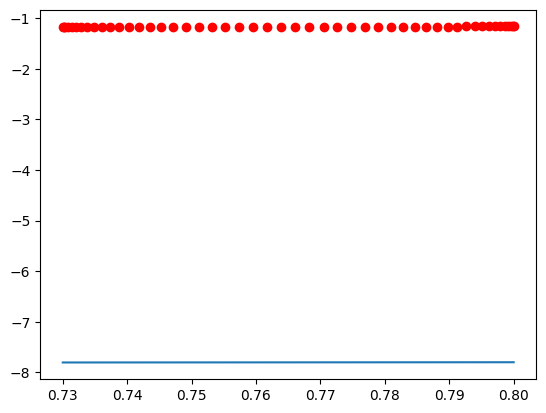

In [10]:
chebyfit = np.polynomial.Chebyshev.fit(r_array_g, cavity_free_E_array_CO[:,0], 49)
print(chebyfit)

cheby_array = np.zeros((1, N_R))
for i in range(N_R):
    cheby_array[0,i] = -7.83315327 + 0.01665548 * (r_array_g[i]) + 0.03414176 * (r_array_g[i]) ** 2 # - 0.02189794 * r_array[i] ** 3 + 0.00669785 * r_array[i] ** 4
cheby_list = np.ndarray.flatten(cheby_array)

print(cheby_array)
plt.plot(r_array_g, cavity_free_E_array_CO[:,0], 'ro')
plt.plot(r_array_g, cheby_list)
plt.show

## Calculation of the Huang-Rhys Factor
Huang Rhys factor can be calculated by both

$$ S = 1/2(\Delta x / x_0)^2 \tag{Turner}$$

from the mode anharmonicity paper

and 

$$ S = \frac{m\omega_{vib} \Delta x^2}{2 \hbar} \tag{Hsu}$$

from the polaritonic Huang-Rhys factor paper

In [14]:
# Constants and Variables
min_S0_loc = np.argmin(cavity_free_E_array_e[:,0])
min_S1_loc = np.argmin(cavity_free_E_array_e[:,1])
print(f'Min on S0 is {r_array_e[min_S0_loc]}')
print(f'Min on S1 is {r_array_e[min_S1_loc]}')
x_0 = wfn_CO.frequency_analysis["Xtp0"].data[5]
delta_au = (r_array_e[min_S1_loc] - r_array_e[min_S0_loc]) / psi4.constants.bohr2angstroms
delta_m = (r_array_e[min_S1_loc] - r_array_e[min_S0_loc]) * 10 ** (-10)
omega_vib = np.sqrt(k_num / mu_kg)
h_bar = constants.hbar
r_eq = r_array_e[min_S0_loc]

# Turner
S_Turner = 0.5 * (delta_au / x0_au) ** 2

# Hsu
S_Hsu = mu_kg * omega_vib * delta_m ** 2 / (2 * h_bar)

print(S_Turner)
print(S_Hsu)

Min on S0 is 0.7372561878739642
Min on S1 is 3.999193226197971
14.425577585795322
349.78903995483387


In [ ]:
D_e_Hartree = cavity_free_E_array_CO[49,0] - cavity_free_E_array_CO[min_S0_loc,0] 
D_e = 0.09848201074825358
D_e_J = D_e_Hartree * 4.3597 * 10 ** (-18)
alpha_inv_m = np.sqrt(k_SI / (2 * D_e_J))
alpha_inv_Angs = alpha_inv_m * 10 ** (-10)
kappa = 2 * D_e_Hartree * alpha_inv_Angs ** 2
g = -6 * D_e_Hartree * alpha_inv_Angs ** 3
h = 14 * D_e_Hartree * alpha_inv_Angs ** 4

In [ ]:
def quartic_morse(r, De, k, re, g, h):
    return (1 / 2) * k * (r - re) ** 2 + (1 / 6) * g * (r - re) ** 3 + (1 / 24) * h * (r - re) ** 4
    #return De * (1 - np.exp(-k * (r - re))) ** 2 + g * (r - re) ** 3 + h * (r - re) ** 4

# Initial parameter guesses
initial_guess = [D_e, kappa, r_eq, g, h]

# Perform the curve fit
fit_params, covariance = curve_fit(quartic_morse, r_array, cavity_free_E_array_CO[:,0], p0=initial_guess, maxfev=10000)

# Extract the optimized parameters
De_fit, k_fit, re_fit, g_fit, h_fit = fit_params

V_fit = quartic_morse(r_array, De_fit, k_fit, re_fit, g_fit, h_fit)

print(V_fit)

First plot the ground-state potential energy surfaces for LiH inside and outisde the cavity.  The effect of the cavity will raise the energy slightly.

In [ ]:
plt.plot(r_array_e, cavity_free_E_array_e[:,1], 'r-', label='cavity free LiH |g>')
#plt.plot(r_array, cavity_free_E_array_LiH[:,1], 'b-', label='cavity free LiH |e>')
plt.plot(r_array, V_fit, label='fit')
plt.legend()
plt.show()



Next plot the ground state surface shifted by the cavity energy and the first excited state surface of 
LiH outside the cavity along with the lower- and upper-polariton surfaces from LiH inside the cavity.
Note that lower polariton surface intersects with another surface for the molecule in the cavity (see the crossing of the red and green curves around r = 1.5 Angstroms); the polariton surface is smooth, so we should really re-sort the eigenvalues around this point. Ruby has some experience doing this. 

In [ ]:
plt.plot(r_array, cavity_free_E_array_CO[:,0]+0.12086, label='cavity free |g>+$\omega$')
plt.plot(r_array, cavity_free_E_array_CO[:,1], label='cavity free |e>')
plt.plot(r_array, cavity_E_array_CO[:,1], label='cavity |LP>')
plt.plot(r_array, cavity_E_array_CO[:,2], label='cavity |LP>')
plt.plot(r_array, cavity_E_array_CO[:,3], label='cavity |UP>')
plt.xlim(1.0, 2.2)
plt.ylim(-7.78, -7.63)
plt.legend()
plt.show()